# Project 4 - Advanced Lane Lines

## Steps:

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
5. Detect lane lines
6. Determine the lane curvature

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob
import pickle
from moviepy.editor import VideoFileClip

%matplotlib inline

### 1. Camera calibration

In [2]:
# Define a set of object points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Define arrays to store object (3D space) and image (2D space) points from imported images
objpoints = []
imgpoints = []

# print a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Iterate through the list, searching for chesseboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use cv2 to find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        print('working on ', fname)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw the found corners, save images to the output_images folder
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found' + str(idx) + '.jpg'
        cv2.imwrite('./output_images/chessboard_images/' + write_name, img)
        
# Load image for reference
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Perform camera calibration for the given object and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the calibration file
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/calibration_pickle.p", "wb"))

working on  ./camera_cal\calibration10.jpg
working on  ./camera_cal\calibration11.jpg
working on  ./camera_cal\calibration12.jpg
working on  ./camera_cal\calibration13.jpg
working on  ./camera_cal\calibration14.jpg
working on  ./camera_cal\calibration15.jpg
working on  ./camera_cal\calibration16.jpg
working on  ./camera_cal\calibration17.jpg
working on  ./camera_cal\calibration18.jpg
working on  ./camera_cal\calibration19.jpg
working on  ./camera_cal\calibration2.jpg
working on  ./camera_cal\calibration20.jpg
working on  ./camera_cal\calibration3.jpg
working on  ./camera_cal\calibration6.jpg
working on  ./camera_cal\calibration7.jpg
working on  ./camera_cal\calibration8.jpg
working on  ./camera_cal\calibration9.jpg


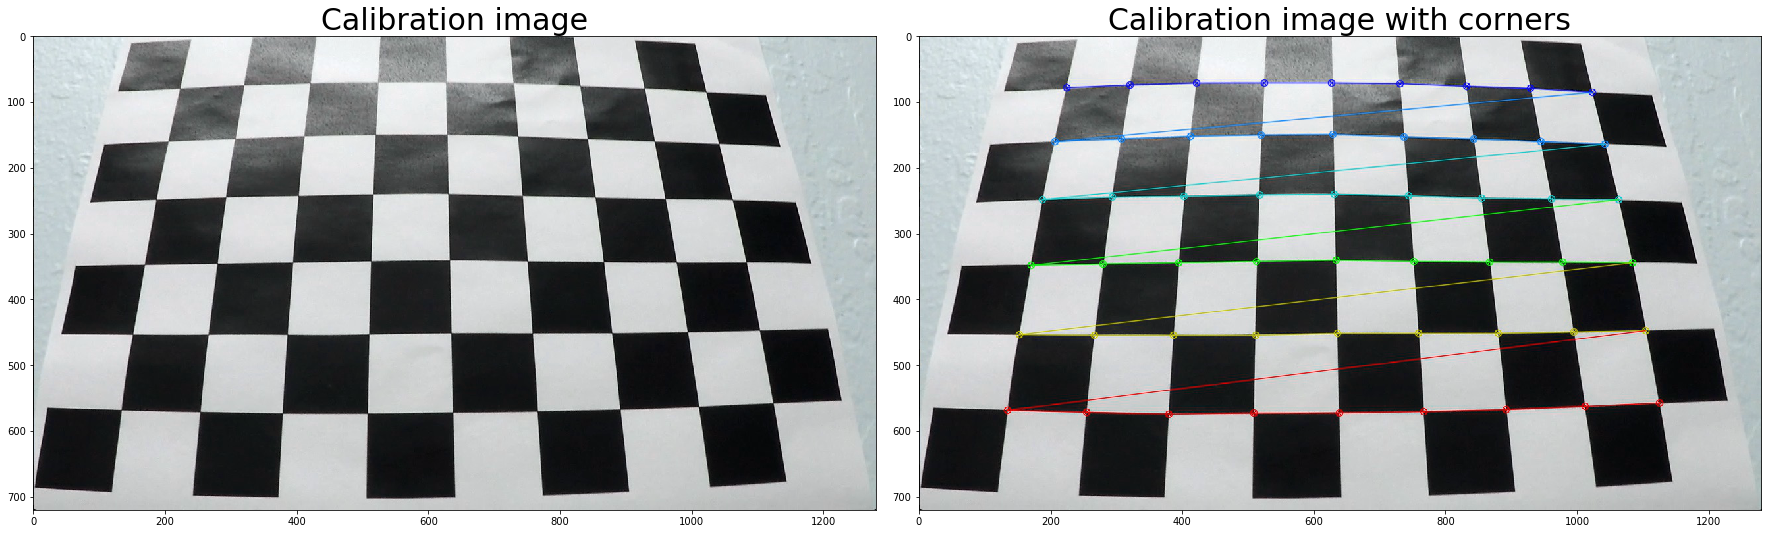

In [3]:
# Plot an example of the calibration image and after finding corners

cal_img_3 = cv2.imread('./camera_cal/calibration3.jpg')
foundlines_img_13 = cv2.imread('./output_images/chessboard_images/corners_found13.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_img_3)
ax1.set_title('Calibration image', fontsize=30)
ax2.imshow(foundlines_img_13, cmap='gray')
ax2.set_title('Calibration image with corners', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 2. Distortion correction

In [18]:
# Load camera calibration data
pickle_data = pickle.load(open("camera_cal/calibration_pickle.p", "rb"))
mtx = pickle_data['mtx']
dist = pickle_data['dist']

# Load test images
test_image_filepaths = glob.glob('./test_images/*.jpg')
test_image_filenames = [f.split('\\')[-1] for f in test_image_filepaths]
test_images = [cv2.imread(f) for f in test_image_filepaths]

# Undistort images
undistort_images = [cv2.undistort(i, mtx, dist, None, mtx) for i in test_images]

### 3. Color/gradient threshold

In [19]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def color_threshold(image, sthresh=(0, 255), vthresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s_channel = hls[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel < sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel < vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

def thresholdImage(image):
    gradx = abs_sobel_thresh(image, orient='x', thresh=(12,100))
    grady = abs_sobel_thresh(image, orient='y', thresh=(25,100))
    c_binary = color_threshold(image, sthresh=(100, 255), vthresh=(50, 255))
    combined = np.zeros_like(c_binary)
    combined[((gradx == 1) & (grady == 1)) | (c_binary == 1)] = 255
    return combined

# Do thresholding
threshold_images = [thresholdImage(i) for i in undistort_images]

In [53]:
saveImages(threshold_images, './test_images/thresholded', test_image_filenames)

Saved file: ./test_images/thresholded\straight_lines1.jpg
Saved file: ./test_images/thresholded\straight_lines2.jpg
Saved file: ./test_images/thresholded\test1.jpg
Saved file: ./test_images/thresholded\test2.jpg
Saved file: ./test_images/thresholded\test3.jpg
Saved file: ./test_images/thresholded\test4.jpg
Saved file: ./test_images/thresholded\test5.jpg
Saved file: ./test_images/thresholded\test6.jpg


### 4. Perspective transform

In [10]:
def plotTransformImages(imgs, titles, dots):
    fig = plt.figure(figsize=(14, 10))
    for i, img in enumerate(imgs):
        plt.subplot(1, 2, i + 1)
        plt.title(titles[i])
        plt.imshow(img, cmap='gray')
        plt.plot(dots[i][0][0], dots[i][0][1], 'r.', ms=12) # top right
        plt.plot(dots[i][1][0], dots[i][1][1], 'r.', ms=12) # bottom right
        plt.plot(dots[i][2][0], dots[i][2][1], 'r.', ms=12) # bottom left
        plt.plot(dots[i][3][0], dots[i][3][1], 'r.', ms=12) # top left
    plt.show()
    
def transformImage(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

# Transformation coordinates
src = np.float32([[693, 455],[1075, 700],[230, 700],[588, 455]])
dst = np.float32([[950, 0],[950, 720],[250, 720],[250, 0]])

# Do transformation
transformed_images = [transformImage(i,src,dst) for i in threshold_images]

In [56]:
saveImages(transformed_images, './test_images/transformed', test_image_filenames)

Saved file: ./test_images/transformed\straight_lines1.jpg
Saved file: ./test_images/transformed\straight_lines2.jpg
Saved file: ./test_images/transformed\test1.jpg
Saved file: ./test_images/transformed\test2.jpg
Saved file: ./test_images/transformed\test3.jpg
Saved file: ./test_images/transformed\test4.jpg
Saved file: ./test_images/transformed\test5.jpg
Saved file: ./test_images/transformed\test6.jpg


### 5. Detect lane lines

In [11]:
def debugPlot(img, signal):
    plt.figure()
    plt.axes().get_yaxis().set_visible(False)
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.figure()
    plt.axes().get_yaxis().set_visible(False)
    plt.plot(signal)
    plt.xlim((0,img.shape[1]))
    plt.show()
    return None

def findWindowCentroids(img, window_width, rows, margin=40, last_centroids=[0, 0], DEBUG=False):
    window_centroids = []
    window_height = int(img.shape[0] / rows)
    half_image_width = int(img.shape[1]/2)
    left_lane_x = last_centroids[0]
    right_lane_x = last_centroids[1]
    left_start = 0 if left_lane_x == 0 else left_lane_x - margin
    left_end = half_image_width - 1 if left_lane_x == 0 else left_lane_x + margin
    right_start = half_image_width if right_lane_x == 0 else right_lane_x - margin
    right_end = img.shape[1] - 1 if right_lane_x == 0 else right_lane_x + margin
    
    for i, y_window_pos in enumerate(range(img.shape[0], 0, -window_height)):
        row_image = img[y_window_pos - window_height: y_window_pos]
        conv_signal = np.convolve(np.ones(window_width), np.sum(row_image, axis=0))
        
        if DEBUG:
            return debugPlot(row_image, conv_signal)
            
        if window_centroids:
            left_lane_x, right_lane_x = window_centroids[-1]
            left_start = left_lane_x - margin
            left_end = left_lane_x + margin
            right_start = right_lane_x - margin
            right_end = right_lane_x + margin

        if np.max(conv_signal[left_start:left_end]) > 0:
            left_lane_x = np.argmax(conv_signal[left_start:left_end]) + left_start
        
        if np.max(conv_signal[right_start:right_end]) > 0:
            right_lane_x = np.argmax(conv_signal[right_start:right_end]) + right_start
        
        window_centroids.append((left_lane_x,right_lane_x))

    return np.array(window_centroids) - window_width / 2

def updateMask(mask, window_width, rows, image_shape, center, level):
    window_height = image_shape[0] / rows
    height_start = int(image_shape[0] - (level + 1) * window_height)
    height_end = int(image_shape[0] - level * window_height)
    width_start = max(0, int(center - window_width / 2))
    width_end = min(int(center + window_width / 2), image_shape[1])
    mask[height_start:height_end, width_start:width_end] = 255

def getWindowOverlayImage(image, window_centroids, window_width, rows):
    zeros = np.zeros_like(image)
    mask = np.zeros_like(image)
    
    # Go through each level and update window mask
    for i, centroid in enumerate(window_centroids):
        updateMask(mask, window_width, rows, image.shape, centroid[0], i)
        updateMask(mask, window_width, rows, image.shape, centroid[1], i)

    # Make window pixels green
    windows = np.array(cv2.merge((zeros, np.array(mask), zeros)), np.uint8)
    # Overlay the orignal road image with window results
    return cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), 0.5, windows, 0.5, 0.0)

def getLaneImages(images, window_width, window_rows):
    output_images = []
    output_centroids = []
    for image in images:
        centroids = findWindowCentroids(image, window_width, window_rows)
        output_images.append(getWindowOverlayImage(image, centroids, window_width, window_rows))
        output_centroids.append(centroids)
    
    return output_images, output_centroids

# Detect lanes on all birds eye test images
detected_lane_images, detected_centroids = getLaneImages(transformed_images, 50, 8)

Window and histogram example:


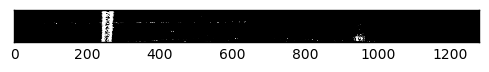

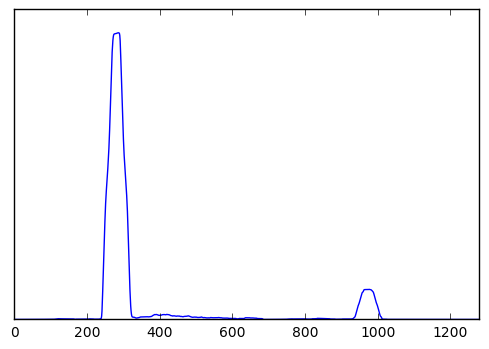

In [13]:
print('Window and histogram example:')
findWindowCentroids(transformed_images[0], 50, 8, DEBUG=True)

In [58]:
saveImages(detected_lane_images, './test_images/detected_lanes', test_image_filenames)

Saved file: ./test_images/detected_lanes\straight_lines1.jpg
Saved file: ./test_images/detected_lanes\straight_lines2.jpg
Saved file: ./test_images/detected_lanes\test1.jpg
Saved file: ./test_images/detected_lanes\test2.jpg
Saved file: ./test_images/detected_lanes\test3.jpg
Saved file: ./test_images/detected_lanes\test4.jpg
Saved file: ./test_images/detected_lanes\test5.jpg
Saved file: ./test_images/detected_lanes\test6.jpg


### 6. Determine the lane curvature

In [12]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
def textOverlay(img, res_yvals, yvals, leftx, left_fitx, right_fitx):
    
    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx, np.float32) * xm_per_pix, 2)
    curverad = ((1 + (2 * curve_fit_cr[0] * yvals[-1] * ym_per_pix + curve_fit_cr[1])**2)**1.5) / np.absolute(2*curve_fit_cr[0])
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center-img.shape[1]/2) * xm_per_pix
    side_pos = 'left'
    
    if center_diff <= 0:
        side_pos = 'right'
    
    cv2.putText(img, 'Radius of Curvature = ' + str(round(curverad, 3)) + 'm', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, 
        (255,255,255), 2)
    cv2.putText(img, 'Vehicle is ' + str(abs(round(center_diff,3))) + 'm ' + side_pos + ' of center', (50,100), 
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    

def drawLane(img, centroids, transformed):
    
    img = img.copy()
    leftx = [i[0] for i in centroids]
    rightx = [i[1] for i in centroids]
    
    yvals = range(img.shape[0])
    res_yvals = np.arange(img.shape[0]-(img.shape[0]/16), 0, -img.shape[0] / len(centroids) )
    
    # f(x) = Ax**2 + Bx + C
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = np.array(left_fit[0] * yvals * yvals +  left_fit[1] * yvals + left_fit[2], np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = np.array(right_fit[0] * yvals * yvals +  right_fit[1] * yvals + right_fit[2], np.int32)
    
    textOverlay(img, res_yvals, yvals, leftx, left_fitx, right_fitx)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warp_zero = np.zeros_like(transformed).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # Combine the result with the original image

    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

lane_images = [drawLane(i, c, t) for i, c, t in zip(undistort_images, detected_centroids, transformed_images)]


In [16]:
saveImages(lane_images, './test_images/result', test_image_filenames)

Saved file: ./test_images/result\straight_lines1.jpg
Saved file: ./test_images/result\straight_lines2.jpg
Saved file: ./test_images/result\test1.jpg
Saved file: ./test_images/result\test2.jpg
Saved file: ./test_images/result\test3.jpg
Saved file: ./test_images/result\test4.jpg
Saved file: ./test_images/result\test5.jpg
Saved file: ./test_images/result\test6.jpg


### 7. Video

In [16]:
min_left_lane = []
max_left_lane = []
min_right_lane = []
max_right_lane = []

def processImage(image):
    img_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    img_thresholded = thresholdImage(img_undistorted)
    img_transformed = transformImage(img_thresholded, src, dst)
    centroids = findWindowCentroids(img_transformed, 50, 8)
    
    min_left_lane.append(centroids[:,0].min())
    max_left_lane.append(centroids[:,0].max())
    min_right_lane.append(centroids[:,1].min())
    max_right_lane.append(centroids[:,1].max())
    
    return drawLane(img_undistorted, centroids, img_transformed)
    
input_video = './project_video.mp4'
output_video = './videos/out_project_video.mp4'

clip = VideoFileClip(input_video)
video_clip = clip.fl_image(processImage)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./videos/out_project_video.mp4
[MoviePy] Writing video ./videos/out_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:34<00:00,  8.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./videos/out_project_video.mp4 



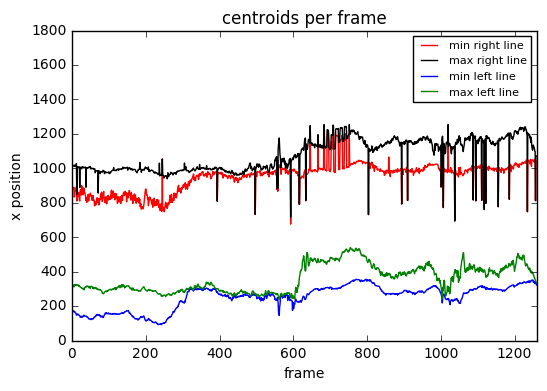

In [18]:
plt.plot(min_right_lane, label='min right line', color='red')
plt.plot(max_right_lane, label='max right line', color='black')
plt.plot(min_left_lane, label='min left line')
plt.plot(max_left_lane, label='max left line')
plt.title('centroids per frame')
plt.xlabel('frame')
plt.ylabel('x position')
plt.xlim([0,len(max_left_lane)])
plt.ylim([0,1800])
plt.legend(loc='upper right', prop={'size':8})
plt.show()

In [19]:
min_left_lane = []
max_left_lane = []
min_right_lane = []
max_right_lane = []

start_centroid = [0, 0]
smooth_centroids = collections.deque(maxlen=5)

def processImageSmooth(image):
    global smooth_centroids
    global start_centroid
    img_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    img_thresholded = thresholdImage(img_undistorted)
    img_transformed = transformImage(img_thresholded, src, dst)
    centroids = findWindowCentroids(img_transformed, 50,8, margin=50, last_centroids=start_centroid)
    
    smooth_centroids.append(centroids)
    smooth_centroids_np = np.array(smooth_centroids)
    new_centroids = smooth_centroids_np.mean(axis=0).astype(int)
    start_centroid = new_centroids[0]
    
    min_left_lane.append(new_centroids[:,0].min())
    max_left_lane.append(new_centroids[:,0].max())
    min_right_lane.append(new_centroids[:,1].min())
    max_right_lane.append(new_centroids[:,1].max())
    
    #DEBUG / TESTS
    #lanes = getWindowOverlayImage(img_transformed, centroids, 50, 8)
    #return_img = drawLane(img_undistorted, new_centroids, img_transformed)
    #img_threshold_3 = cv2.cvtColor(img_thresholded, cv2.COLOR_GRAY2RGB)
    #img_transformed_3 = cv2.cvtColor(img_transformed, cv2.COLOR_GRAY2RGB)
    #blank_image = np.zeros((image.shape[0],image.shape[1]+426, 3), np.uint8)
    #blank_image[0:img_threshold_3.shape[0],0:img_threshold_3.shape[1]] = return_img
    #blank_image[0:240,lane_images[0].shape[1]:] = cv2.resize(img_threshold_3,(426, 240))
    #blank_image[240:480,lane_images[0].shape[1]:] = cv2.resize(img_transformed_3,(426, 240))
    #blank_image[480:,lane_images[0].shape[1]:] = cv2.resize(lanes,(426, 240))
    
    return drawLane(img_undistorted, new_centroids, img_transformed)
    
input_video = './videos/project_video.mp4'
output_video = './videos/out_project_video_5.mp4'

clip = VideoFileClip(input_video)#.subclip(27,30)
video_clip = clip.fl_image(processImageSmooth)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./videos/out_project_video_5.mp4
[MoviePy] Writing video ./videos/out_project_video_5.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:37<00:00,  8.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./videos/out_project_video_5.mp4 



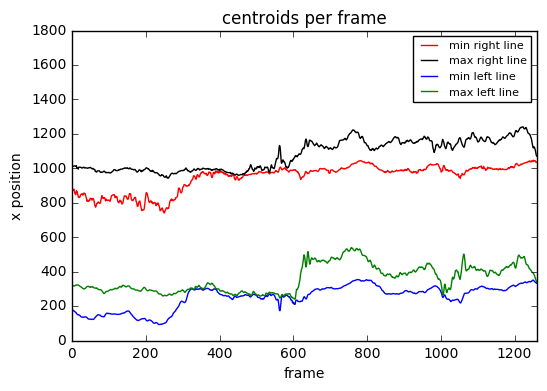

In [20]:
plt.plot(min_right_lane, label='min right line', color='red')
plt.plot(max_right_lane, label='max right line', color='black')
plt.plot(min_left_lane, label='min left line')
plt.plot(max_left_lane, label='max left line')
plt.title('centroids per frame')
plt.xlabel('frame')
plt.ylabel('x position')
plt.xlim([0,len(max_left_lane)])
plt.ylim([0,1800])
plt.legend(loc='upper right', prop={'size':8})
plt.show()

 ## 8. Challenge Videos

In [62]:
clip_challenge = VideoFileClip('./videos/challenge_video.mp4')

challenge_images = []
challenge_images.append(clip_challenge.get_frame(0))
challenge_images.append(clip_challenge.get_frame(2))
challenge_images.append(clip_challenge.get_frame(5))

challenge_images = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in challenge_images]
challenge_images = [cv2.undistort(i, mtx, dist, None, mtx) for i in challenge_images]

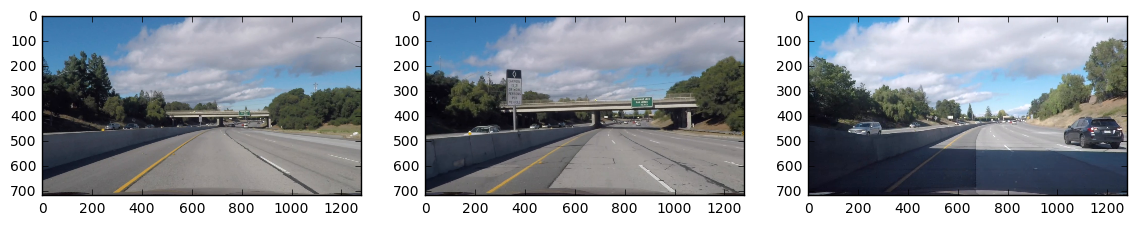

In [63]:
plotImages(1,3, challenge_images, ['']*len(challenge_images))

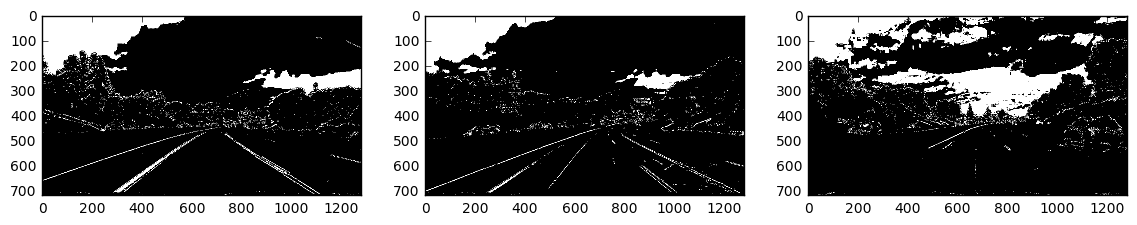

In [66]:
thresholded_images = [thresholdImage(i) for i in challenge_images]
plotImages(1,3, thresholded_images, ['']*len(thresholded_images))

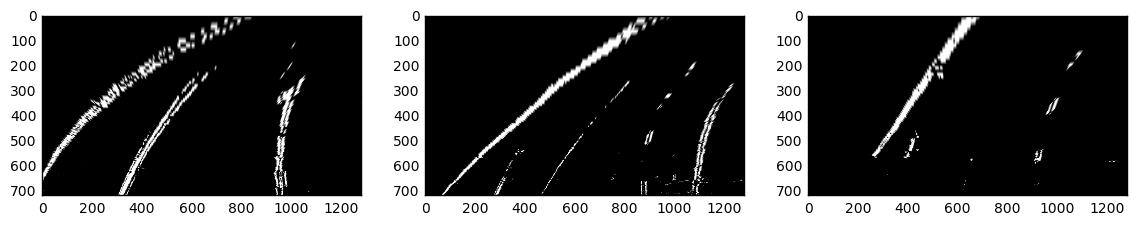

In [67]:
transformed_images = [transformImage(i, src, dst) for i in thresholded_images]
plotImages(1,3, transformed_images, ['']*len(transformed_images))

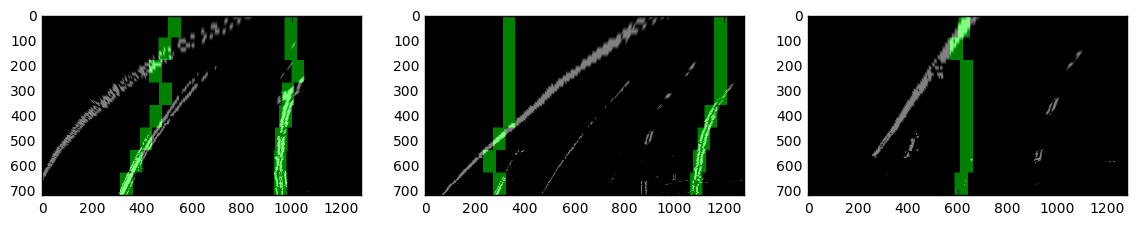

In [68]:
detected_lane_images, detected_centroids = getLaneImages(transformed_images, 50, 8)
plotImages(1,3, detected_lane_images, ['']*len(detected_lane_images))

In [71]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def color_threshold(image, sthresh=(0, 255), vthresh=(0, 255)):
    HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))
    
    # For white
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 60
    HSL = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    white_3 = cv2.inRange(image, (200,200,200), (255,255,255))
    
    #hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    #s_channel = hls[:, :, 2]
    #s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= sthresh[0]) & (s_channel < sthresh[1])] = 1

    #hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #v_channel = hsv[:, :, 2]
    #v_binary = np.zeros_like(v_channel)
    #v_binary[(v_channel >= vthresh[0]) & (v_channel < vthresh[1])] = 1

    #output = np.zeros_like(s_channel)
    #output[(s_binary == 1) & (v_binary == 1)] = 1
    return yellow | white | white_2 | white_3

def thresholdImage(image):
    gradx = abs_sobel_thresh(image, orient='x', thresh=(12,100))
    grady = abs_sobel_thresh(image, orient='y', thresh=(25,100))
    c_binary = color_threshold(image, sthresh=(100, 255), vthresh=(50, 255))
    combined = np.zeros_like(c_binary)
    combined[((gradx == 1) & (grady == 1)) | (c_binary == 1)] = 255
    return combined

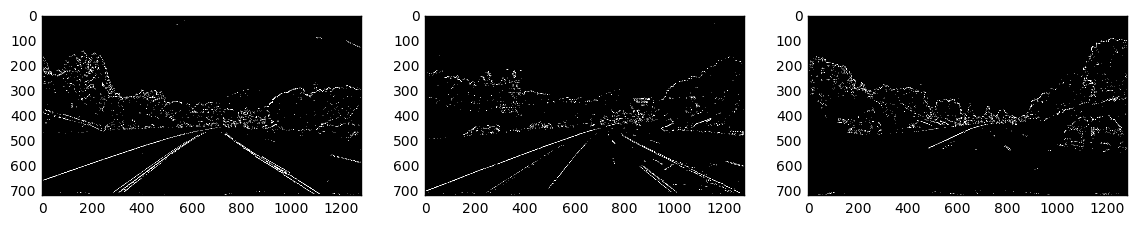

In [72]:
thresholded_images = [thresholdImage(i) for i in challenge_images]
plotImages(1,3, thresholded_images, ['']*len(thresholded_images))

### Tipps Udacity Review

Good job extracting the lane lines! An idea for more robust extraction is to try color thresholding in all the RGB, HSV and HSL channels for your yellows and whites! By using color thresholding you are able to make the lane detection more robust by relying less on gradients for good results! Furthermore, thresholding is a lot faster in terms of processing than gradients!

Here is some sample code to play around with, it should help with more tricky areas!

Your video looks great! Here is something I can share for more challenging videos where you may be unable to capture the lane lines!

You can use cv2.matchShapes as a means to make sure the final warp polygon is of quality before using. OpenCV's matchShapes, compares two shapes and returns a similarly index, with 0 being identical shapes. You can use this to make sure the polygon for your next frame is close to what it is expected to look like and if not you can elect to use old polygon instead. This way you can let your algorithm be really good when it can and when it can just fake it until a few frames later when it produces good results.

Here is an example: